In [18]:
import time
import numpy as np
from scipy.stats import randint as sp_randint
from utils.input_pipeline import load_data
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score


random_state=np.random.RandomState(0)


feature_path= "poster_results/step4_features.csv"

imputer = Imputer()
normalizer = Normalizer()

data_path = "data/full_26_kinase_data.h5"

In [19]:
with open(feature_path, "r") as input_file:
    feature_list = []
    for line in input_file:
        line = line.strip('\n')
        feature_list.append(line)
        
print(len(feature_list))

15


In [20]:
X,y = load_data(data_path,features_list=feature_list)

 15%|█▌        | 4/26 [00:00<00:00, 36.92it/s]

loading 26 proteins.


100%|██████████| 26/26 [00:00<00:00, 45.04it/s]


In [21]:
X_train,X_test,y_train,y_test = train_test_split(normalizer.fit_transform(imputer.fit_transform(X.astype(np.float32))),
                                                 y.astype(np.float32),stratify=y.astype(np.float32),test_size=0.2, random_state=random_state)
del X
del y

In [22]:
rforest = RandomForestClassifier(n_jobs=10,oob_score=True, class_weight='balanced', random_state=random_state)

forest_params = {"n_estimators": sp_randint(15,30),
                 "criterion": ["gini","entropy"]
                }

In [23]:
forest_estimator = RandomizedSearchCV(rforest,forest_params,scoring='f1', random_state=random_state)
forest_estimator.fit(X_train,y_train.flatten())
best_forest = forest_estimator.best_estimator_

/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis

In [24]:
best_forest_preds = best_forest.predict(X_test)
print("accuracy:",accuracy_score(y_test.flatten(),best_forest_preds),"\tf1-score",f1_score(y_test.flatten(),best_forest_preds))

accuracy: 0.985364437934 	f1-score 0.739483394834


In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
support = best_forest.feature_importances_

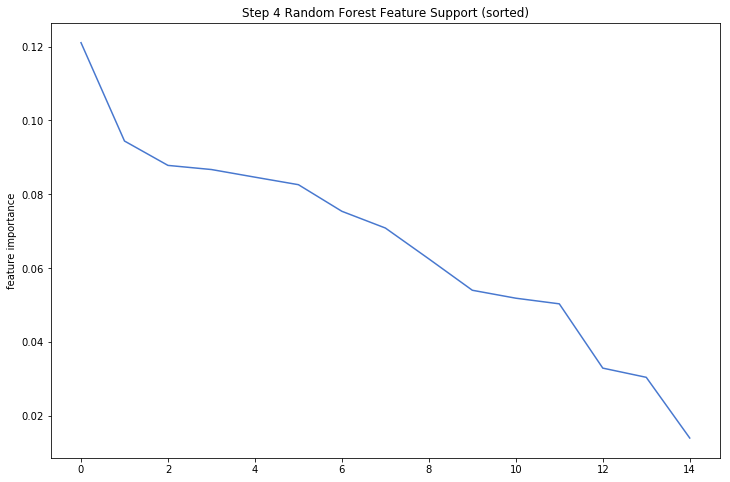

In [26]:
plt.clf()
plt.figure(figsize=[12,8])
plt.plot(np.sort(support)[::-1])
plt.title("Step 4 Random Forest Feature Support (sorted)")
plt.ylabel("feature importance")
plt.savefig("poster_results/feature_importance_curve_step4.png")
plt.show()

In [27]:
import h5py
import pandas as pd
full_features = feature_list

keep_idxs = support > np.mean(support,axis=0)

features_to_keep = np.asarray(full_features)[keep_idxs]

features_to_keep = pd.DataFrame(features_to_keep)
features_to_keep.to_csv("poster_results/step5_features.csv",index=False,header=False)

print(len(full_features),features_to_keep.shape)

15 (8, 1)


In [28]:
from sklearn.linear_model import LogisticRegressionCV
from scipy.stats import uniform
from scipy.stats.distributions import uniform_gen

log_reg = LogisticRegressionCV(class_weight='balanced', random_state=random_state)
log_reg.fit(X_train,y_train.flatten())

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=<mtrand.RandomState object at 0x2b8cebbf5990>,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [29]:
log_reg_preds = log_reg.predict(X_test)
print("accuracy:",accuracy_score(y_test.flatten(),log_reg_preds),"\tf1-score",f1_score(y_test.flatten(),log_reg_preds))

accuracy: 0.790624395367 	f1-score 0.174386920981


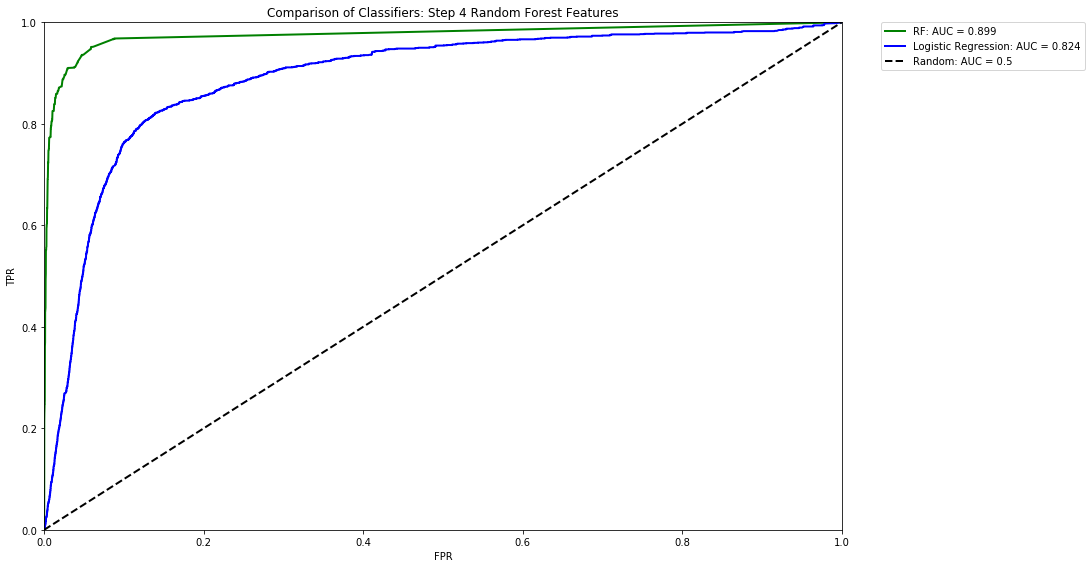

In [30]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-muted")
from sklearn.metrics import roc_curve,roc_auc_score

best_forest_fpr, best_forest_tpr, _ = roc_curve(y_test,best_forest.predict_proba(X_test)[:,1])
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test,log_reg.predict_proba(X_test)[:,1])

plt.clf()
plt.figure(figsize=[12,8])
plt.plot(best_forest_fpr, best_forest_tpr,lw=2, label=("RF: AUC = "+
                                                  str(np.round(roc_auc_score(y_test.flatten(),best_forest.predict(X_test),
                                                                             average='weighted'),3))), color = 'g')
plt.plot(log_reg_fpr, log_reg_tpr,lw=2, label=("Logistic Regression: AUC = "+
                                          str(np.round(roc_auc_score(y_test.flatten(),log_reg.predict(X_test),
                                                                     average='weighted'),3))), color = 'b')
plt.plot([0,1], [0,1], 'r--',lw=2, label="Random: AUC = 0.5", color = 'k')

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Comparison of Classifiers: Step 4 Random Forest Features")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("poster_results/classifier_comparison_step4_features.png",  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

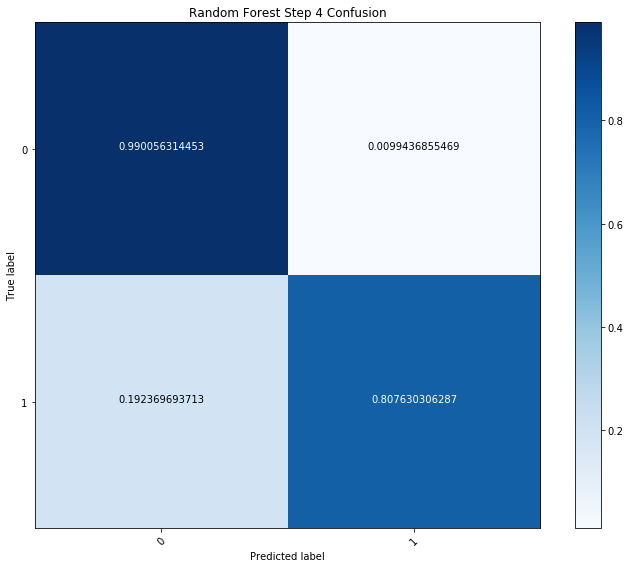

In [32]:
import itertools
from sklearn.metrics import confusion_matrix

rforest_confusion = confusion_matrix(y_test,best_forest_preds)
plt.clf()
plt.figure(figsize=[10,8])
plot_confusion_matrix(rforest_confusion, classes=[0, 1], title="Random Forest Step 4 Confusion")
plt.tight_layout()
plt.savefig("poster_results/random_forest_step4_confusion.png")
plt.show()

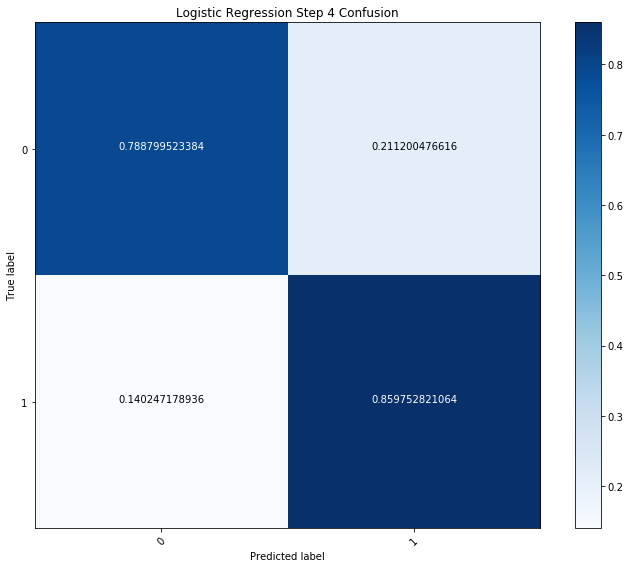

In [33]:
log_reg_confusion = confusion_matrix(y_test,log_reg_preds)
plt.clf()
plt.figure(figsize=[10,8])
plot_confusion_matrix(log_reg_confusion, classes=[0, 1], title="Logistic Regression Step 4 Confusion")
plt.tight_layout()
plt.savefig("poster_results/log_reg_step4_confusion.png")
plt.show()

In [34]:
from sklearn.metrics import classification_report

result_file = open("poster_results/step4_test_results.txt","w")
best_forest_report = classification_report(y_test, best_forest_preds)
log_reg_report = classification_report(y_test,log_reg_preds)

print("Random Forest Test Set Performance\n",best_forest_report)
result_file.write(str("Step 4 Random Forest Test Set Performance\n" + str(best_forest_report)))

print("Logistic Regression Test Set Performance\n",log_reg_report)
result_file.write(str("Step 4 Logistic Regression Test Set Performance\n" + str(log_reg_report)))
result_file.close()

Random Forest Test Set Performance
              precision    recall  f1-score   support

        0.0       0.99      0.99      0.99     70497
        1.0       0.68      0.81      0.74      1861

avg / total       0.99      0.99      0.99     72358

Logistic Regression Test Set Performance
              precision    recall  f1-score   support

        0.0       1.00      0.79      0.88     70497
        1.0       0.10      0.86      0.17      1861

avg / total       0.97      0.79      0.86     72358

